In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName("Analyzing London Crime Data").getOrCreate()

In [5]:
data = spark.read.format("csv").option("header", "true").load("..\\Courses&InputData\\spark-2-getting-started\\02\\demos\\datasets\\london_crime_by_lsoa.csv")
data.printSchema()

root
 |-- lsoa_code: string (nullable = true)
 |-- borough: string (nullable = true)
 |-- major_category: string (nullable = true)
 |-- minor_category: string (nullable = true)
 |-- value: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)



In [6]:
data.limit(5).show()

+---------+----------+--------------------+--------------------+-----+----+-----+
|lsoa_code|   borough|      major_category|      minor_category|value|year|month|
+---------+----------+--------------------+--------------------+-----+----+-----+
|E01001116|   Croydon|            Burglary|Burglary in Other...|    0|2016|   11|
|E01001646| Greenwich|Violence Against ...|      Other violence|    0|2016|   11|
|E01000677|   Bromley|Violence Against ...|      Other violence|    0|2015|    5|
|E01003774| Redbridge|            Burglary|Burglary in Other...|    0|2016|    3|
|E01004563|Wandsworth|             Robbery|   Personal Property|    0|2008|    6|
+---------+----------+--------------------+--------------------+-----+----+-----+



## Clean the data

In [7]:
data1 = data.dropna()
data2 = data.drop('lsoa_code')

data2.show(5)

+----------+--------------------+--------------------+-----+----+-----+
|   borough|      major_category|      minor_category|value|year|month|
+----------+--------------------+--------------------+-----+----+-----+
|   Croydon|            Burglary|Burglary in Other...|    0|2016|   11|
| Greenwich|Violence Against ...|      Other violence|    0|2016|   11|
|   Bromley|Violence Against ...|      Other violence|    0|2015|    5|
| Redbridge|            Burglary|Burglary in Other...|    0|2016|    3|
|Wandsworth|             Robbery|   Personal Property|    0|2008|    6|
+----------+--------------------+--------------------+-----+----+-----+
only showing top 5 rows



In [27]:
data2

DataFrame[borough: string, major_category: string, minor_category: string, value: string, year: string, month: string]

## Borough Stats Analysis

In [8]:
boroughs_set = data2.select('borough').distinct()
boroughs_set.show()

+--------------------+
|             borough|
+--------------------+
|             Croydon|
|          Wandsworth|
|              Bexley|
|             Lambeth|
|Barking and Dagenham|
|              Camden|
|           Greenwich|
|              Newham|
|       Tower Hamlets|
|            Hounslow|
|              Barnet|
|              Harrow|
|Kensington and Ch...|
|           Islington|
|               Brent|
|            Haringey|
|             Bromley|
|              Merton|
|         Westminster|
|             Hackney|
+--------------------+
only showing top 20 rows



In [9]:
boroughs_set.count()

33

In [10]:
hackney_data = data2.filter(data2['borough'] == 'Hackney')
hackney_data.show(5)

+-------+--------------------+--------------------+-----+----+-----+
|borough|      major_category|      minor_category|value|year|month|
+-------+--------------------+--------------------+-----+----+-----+
|Hackney|     Criminal Damage|Criminal Damage T...|    0|2011|    6|
|Hackney|Violence Against ...|          Harassment|    1|2013|    2|
|Hackney|     Criminal Damage|Other Criminal Da...|    0|2011|    7|
|Hackney|Violence Against ...|        Wounding/GBH|    0|2013|   12|
|Hackney|  Theft and Handling|  Other Theft Person|    0|2016|    8|
+-------+--------------------+--------------------+-----+----+-----+
only showing top 5 rows



In [12]:
data_2015_2016 = data2.filter(data2['year'].isin(['2015', '2016']))
data_2015_2016.sample(fraction=.1).show()

+--------------------+--------------------+--------------------+-----+----+-----+
|             borough|      major_category|      minor_category|value|year|month|
+--------------------+--------------------+--------------------+-----+----+-----+
|Kingston upon Thames|  Theft and Handling|    Theft From Shops|    0|2016|   11|
|             Bromley|     Criminal Damage|Criminal Damage T...|    1|2016|    4|
|              Ealing|             Robbery|   Personal Property|    0|2015|    7|
|      Waltham Forest|  Theft and Handling|Motor Vehicle Int...|    0|2016|    3|
|              Newham|  Theft and Handling|Theft/Taking of P...|    0|2016|    3|
|Kensington and Ch...|Other Notifiable ...|    Other Notifiable|    0|2015|    5|
|      Waltham Forest|            Burglary|Burglary in Other...|    0|2015|    6|
|Kensington and Ch...|Other Notifiable ...|    Other Notifiable|    0|2016|   10|
|           Redbridge|Violence Against ...| Assault with Injury|    2|2015|   12|
|           Redb

In [13]:
borough_crime_count = data2.groupBy('borough').count()
borough_crime_count.show(5)

+--------------------+------+
|             borough| count|
+--------------------+------+
|             Croydon|602100|
|          Wandsworth|498636|
|              Bexley|385668|
|             Lambeth|519048|
|Barking and Dagenham|311040|
+--------------------+------+
only showing top 5 rows



In [17]:
borough_conviction_sum = data2.groupBy('borough').agg({'value': 'sum'})\
                              .withColumnRenamed('sum(value)', 'convictions').orderBy('convictions', ascending=False)
borough_conviction_sum.show(5)

+-----------+-----------+
|    borough|convictions|
+-----------+-----------+
|Westminster|   455028.0|
|    Lambeth|   292178.0|
|  Southwark|   278809.0|
|     Camden|   275147.0|
|     Newham|   262024.0|
+-----------+-----------+
only showing top 5 rows



In [19]:
total_convictions = borough_conviction_sum.agg({'convictions':'sum'})\
                                          .withColumnRenamed('sum(convictions)', 'total_convictions')
total_convictions.show()

+-----------------+
|total_convictions|
+-----------------+
|        6447758.0|
+-----------------+



In [20]:
total_convictions = total_convictions.collect()[0][0]
import pyspark.sql.functions as func
borough_perc_contribution = borough_conviction_sum.withColumn(
    '% contribution', 
    func.round(borough_conviction_sum.convictions / total_convictions * 100, 2))
borough_perc_contribution.printSchema()

root
 |-- borough: string (nullable = true)
 |-- convictions: double (nullable = true)
 |-- % contribution: double (nullable = true)



In [21]:
 borough_perc_contribution.orderBy(borough_perc_contribution[2].desc()).show(5)

+-----------+-----------+--------------+
|    borough|convictions|% contribution|
+-----------+-----------+--------------+
|Westminster|   455028.0|          7.06|
|    Lambeth|   292178.0|          4.53|
|  Southwark|   278809.0|          4.32|
|     Camden|   275147.0|          4.27|
|     Newham|   262024.0|          4.06|
+-----------+-----------+--------------+
only showing top 5 rows



In [26]:
from pyspark.sql.types import IntegerType
conviction_monthly_2014 = data2.filter(data2['year'] == '2014').groupBy('month').agg({'value': 'sum'})\
                               .withColumnRenamed('sum(value)', 'convictions')
conviction_monthly_2014 = conviction_monthly_2014.withColumn('month', conviction_monthly_2014['month'].cast(IntegerType()))\
                                                 .orderBy('month')
total_convictions_2014 = conviction_monthly_2014.agg({'convictions': 'sum'}).collect()[0][0]
conviction_monthly_2014 = conviction_monthly_2014.withColumn(
    '% contribution',
    func.round(conviction_monthly_2014.convictions / total_convictions_2014 * 100, 2))
conviction_monthly_2014.show()

+-----+-----------+--------------+
|month|convictions|% contribution|
+-----+-----------+--------------+
|    1|    55515.0|          8.16|
|    2|    51222.0|          7.53|
|    3|    57669.0|          8.48|
|    4|    53467.0|          7.86|
|    5|    56327.0|          8.28|
|    6|    57039.0|          8.39|
|    7|    58564.0|          8.61|
|    8|    55641.0|          8.18|
|    9|    56933.0|          8.37|
|   10|    60537.0|           8.9|
|   11|    59704.0|          8.78|
|   12|    57565.0|          8.46|
+-----+-----------+--------------+



## major_category stats analysis

In [30]:
crimes_category = data2.groupBy('major_category').agg({'value': 'sum'}).withColumnRenamed('sum(value)', 'convictions')
crimes_category.orderBy('convictions', ascending=False).show()

+--------------------+-----------+
|      major_category|convictions|
+--------------------+-----------+
|  Theft and Handling|  2661861.0|
|Violence Against ...|  1558081.0|
|            Burglary|   754293.0|
|     Criminal Damage|   630938.0|
|               Drugs|   470765.0|
|             Robbery|   258873.0|
|Other Notifiable ...|   106349.0|
|    Fraud or Forgery|     5325.0|
|     Sexual Offences|     1273.0|
+--------------------+-----------+



In [31]:
year_df = data2.select('year')
year_df.agg({'year': 'min'}).show()

+---------+
|min(year)|
+---------+
|     2008|
+---------+



In [32]:
year_df.agg({'year': 'max'}).show()

+---------+
|max(year)|
+---------+
|     2016|
+---------+



In [33]:
year_df.describe().show()

+-------+-----------------+
|summary|             year|
+-------+-----------------+
|  count|         13490604|
|   mean|           2012.0|
| stddev|2.581988993167432|
|    min|             2008|
|    max|             2016|
+-------+-----------------+



In [35]:
 data2.crosstab('borough', 'major_category')\
      .select('borough_major_category', 'Burglary', 'Drugs', 'Fraud or Forgery', 'Robbery')\
      .show()

+----------------------+--------+-----+----------------+-------+
|borough_major_category|Burglary|Drugs|Fraud or Forgery|Robbery|
+----------------------+--------+-----+----------------+-------+
|              Havering|   32400|32616|            5508|  27648|
|                Merton|   26784|29160|            5724|  23652|
|              Haringey|   31320|35424|           10368|  29484|
|         Tower Hamlets|   31104|37368|            5400|  28512|
|               Bromley|   42552|42336|            8532|  34668|
|               Enfield|   39528|44064|            9720|  35532|
|  Kingston upon Thames|   21168|22140|            3780|  15660|
|           Westminster|   27648|32616|            8748|  25056|
|  Richmond upon Thames|   24840|23004|            2808|  18468|
|              Lewisham|   36504|43740|           11016|  34884|
|                 Brent|   37368|46980|            9288|  34128|
|  Barking and Dagenham|   23760|26244|            7236|  22248|
|             Redbridge| 

In [36]:
get_ipython().magic('matplotlib inline')
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [48]:
def describe_year(yr):
    yearly_details = data2.filter(data2.year == yr).groupBy('borough')\
                          .agg({'value': 'sum'}).withColumnRenamed('sum(borough)', 'convictions')
    
    borough_list = [x[0] for x in yearly_details.toLocalIterator()]
    convictions_list = [x[1] for x in yearly_details.toLocalIterator()]
    
    plt.figure(figsize=(33, 10))
    plt.bar(borough_list, convictions_list)
    
    plt.title('Crime Rates for the year: ' + yr, fontsize=30)
    plt.xlabel('Boroughs', fontsize=30)
    plt.ylabel('Convictions', fontsize=30)
    
    plt.xticks(rotation=90, fontsize=30)
    plt.yticks(fontsize=30)
    plt.autoscale()
    plt.show()

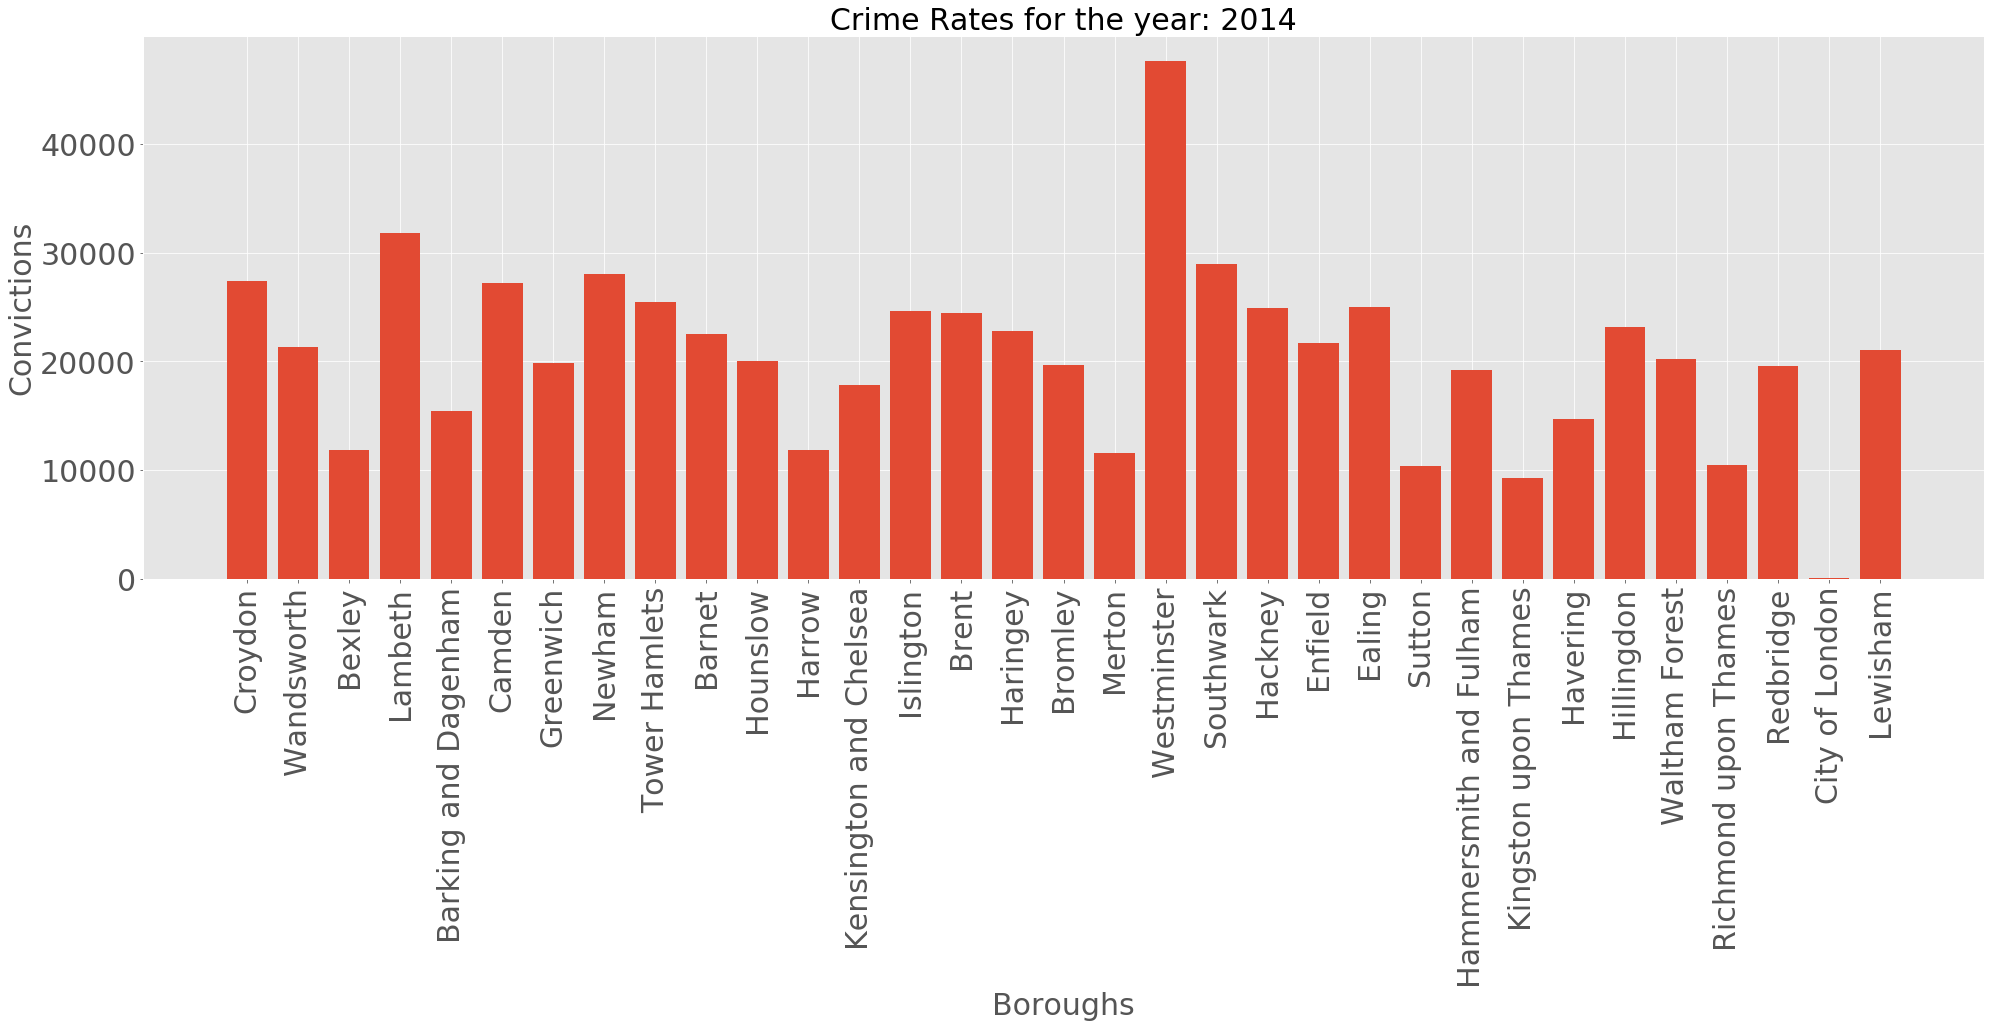

In [49]:
describe_year('2014')